Sealevel monitor
========

This document is used to monitor the current sea level along the Dutch coast. The sea level is measured using a number of tide gauges. Six long running tide gauges are considered "main stations". The mean of these stations is used to estimate the "current sea-level rise". The measurements since 1890 are taken into account. Measurements before that are considered less valid because the Amsterdam Ordnance Datum was not yet normalized. 

In [37]:
# this is a list of packages that are used in this notebook
# these come with python
import io
import zipfile
import functools
import bisect
import datetime
import pathlib

import sys
before = {str(m) for m in sys.modules}
# you can install these packages using pip or anaconda
# (requests numpy pandas bokeh pyproj statsmodels)

# for downloading
import requests
import netCDF4

# computation libraries
import numpy as np
import pandas as pd


# coordinate systems
import pyproj 

# statistics
import statsmodels.api as sm
import statsmodels.multivariate.pca
import statsmodels.tsa.seasonal


# plotting
import bokeh.io
import bokeh.plotting
import bokeh.tile_providers
import bokeh.palettes

# this package gives a lot of warnings about incompatibility with 3.1 
# replace 
import windrose
import matplotlib.colors
import matplotlib.cm
import matplotlib.pyplot as plt
matplotlib.projections.register_projection(windrose.WindroseAxes)
import cmocean.cm

# displaying things
from ipywidgets import Image
import IPython.display

# add the top level package
import slr.models
import slr.psmsl
import slr.wind
import slr.plots
import slr.tables


import slr

In [38]:
# If this notebook is not showing up with figures, you can use the following url:
# https://nbviewer.ipython.org/github/openearth/notebooks/blob/master/sealevelmonitor.ipynb
bokeh.io.output_notebook()
# we're using matplotlib for polar plots (non-interactive)
%matplotlib inline
# does not work properly
# %matplotlib notebook

# use local data, make sure you updated the datasets with the makefiles
local = True

drop_delfzijl = True
wind_product = 'NCEP1'
subtract_surge = True
reference_point_wind = {"lat": 53, "lon": 3}

default_dataset_name = 'rlr_annual'
# wind_product = '20CR'
# wind_product = 'combined'

src_dir = slr.get_src_dir()


Loading BokehJS ...

Sea-level measurements
=============
In this section we download sea-level measurements. The global collection of tide gauge records at the PSMSL is used to access the data. The other way to access the data is to ask the service desk data at Rijkswaterstaat. There are two types of datasets the "Revised Local Reference" and "Metric". For the Netherlands the difference is that the "Revised Local Reference" undoes the corrections from the  NAP correction in 2014, to get a consistent dataset. Here we transform the RLR back to NAP (without undoing the correction).

**Check:** Make sure that you verify the rlr2nap parameters.

The rlrnap computes the rlr back to  latest NAP (ignoring the undoing of the NAP correction) the alpha paramater is the dominant wind direction for the stations, based on de Ronde 2013. Id's are the station ids in the PSMSL dataset. They may change from year to year as the PSMSL 0 point is arbitary. You can lookup the relevant parameters in the schematic diagram like this: https://www.psmsl.org/data/obtaining/rlr.diagrams/20.php

In [39]:
zipfiles = slr.psmsl.get_zipfiles()
main_stations = slr.psmsl.get_main_stations()



In [40]:
# Check these numbers with the table
main_stations[['name', 'psmsl_id', 'msl-rlr', 'msl-nap', 'nap-rlr']]

,name,psmsl_id,msl-rlr,msl-nap,nap-rlr
id,,,,,
20,Vlissingen,20,6976,46,6930
22,Hoek van Holland,22,6987,114,6873
23,Den Helder,23,6962,16,6946
24,Delfzijl,24,6953,130,6823
25,Harlingen,25,7024,110,6914
32,IJmuiden,32,7014,64,6950


In [41]:
# the main stations are defined by their ids
main_stations_idx = list(main_stations.index)
main_stations_idx

[20, 22, 23, 24, 25, 32]

In [42]:
# download the zipfile

zipfile = zipfiles[default_dataset_name]
stations = slr.psmsl.get_station_list(zipfiles[default_dataset_name], dataset_name=default_dataset_name)
# the dutch stations in the PSMSL database, make a copy
# or use stations.coastline_code == 150 for all dutch stations
selected_stations = pd.merge(main_stations, stations, left_index=True, right_index=True, suffixes=['_rws', '_psmsl'])
# set the main stations, this should be a list of 6 stations
selected_stations['name'] = selected_stations['name_rws']
selected_stations

,name_rws,msl-rlr,msl-nap,nap-rlr,alpha,ddl_id,location,psmsl_id,foundation_low,station_low,...,lat,lon,name_psmsl,coastline_code,station_code,quality,met_monthly_url,rlr_monthly_url,rlr_annual_url,name
id,,,,,,,,,,,,,,,,,,,,,
20,Vlissingen,6976,46,6930,118,VLISSGN,Vlissingen,20,-17.6,2.50,...,51.442222,3.596111,VLISSINGEN,150,101,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Vlissingen
22,Hoek van Holland,6987,114,6873,117,HOEKVHLD,Hoek van Holland,22,-3.3,5.27,...,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Hoek van Holland
23,Den Helder,6962,16,6946,107,DENHDR,Den Helder,23,-5.0,5.00,...,52.964444,4.745000,DEN HELDER,150,31,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Den Helder
24,Delfzijl,6953,130,6823,117,DELFZL,Delfzijl,24,-20.0,1.85,...,53.326389,6.933056,DELFZIJL,150,1,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Delfzijl
25,Harlingen,7024,110,6914,108,HARLGN,Harlingen,25,-5.4,5.55,...,53.175556,5.409444,HARLINGEN,150,21,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Harlingen
32,IJmuiden,7014,64,6950,110,IJMDBTHVN,IJmuiden,32,-13.0,4.20,...,52.462222,4.554722,IJMUIDEN,150,41,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,IJmuiden


In [43]:
# show the plot
bokeh.io.show(slr.plots.stations_map(stations, selected_stations))

Now that we have defined which tide gauges we are monitoring we can start downloading the relevant data. 

Sea-level explained  
=======
The sea-level is dependent on several factors. We call these factors explanatory, exogenous or independent variables. The main factors that influence the monthly and annual sea level include wind, pressure, river discharge, tide and oscilations in the ocean. Based on previous analysis we include wind and nodal tide as independent variables. To be able to include wind, we use the monthly 10m wind based on the NCEP reanalysis of the NCAR. To be more specific we include the squared u and v wind components. Unfortunately the wind series only go back to 1948. To be able to include them without having to discard the sea level measurements before 1948, we fill in the missing data with the mean. 

We don't include timeseries of climate change related explanatory variables like trends in density and ice loss at Greenland and Antarctica. These are calculated seperately (see analysis notebooks). Here we only include the incidental (storms) and periodic (tide). We also show the irregular periodic North Atlantic Osciliation here, but we don't correct for it, as this metric does not have such a strong correlation with the water level at the Dutch coast, thus including it will also reduce the explainability of the current sea-level rise. 

In [44]:
# Use a point from NCEP 1 as reference point

monthly_wind_products, annual_wind_products = slr.wind.get_wind_products(reference_point_wind=reference_point_wind)

annual_wind_df = annual_wind_products[wind_product]
monthly_wind_df = monthly_wind_products[wind_product]


found point 52.3799 3.75
found point 53.0 3.0


In [45]:
monthly_gtsm_df, annual_gtsm_df = slr.wind.get_gtsm_dfs()
monthly_gtsm_df

,t,name,psmsl_id,ddl_id,latitude,longitude,station_name,surge,year
0,1979-01-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,-0.016918,1979.000000
1,1979-01-01,Delfzijl,24.0,DELFZL,53.326526,6.933405,b'NWS_NO_TS_MO_Delfzijl\r ...,-0.041117,1979.000000
2,1979-01-01,Den Helder,23.0,DENHDR,52.963769,4.743801,b'NWS_NO_TS_MO_DenHelder\r ...,-0.009794,1979.000000
3,1979-01-01,Harlingen,25.0,HARLGN,53.175689,5.411273,b'NWS_NO_TS_MO_Harlingen\r ...,-0.012795,1979.000000
4,1979-01-01,Hoek van Holland,22.0,HOEKVHLD,51.977536,4.119752,b'NWS_NO_TS_MO_HoekVanHolland\r ...,-0.011499,1979.000000
...,...,...,...,...,...,...,...,...,...
3607,2021-08-01,NL,NaN,NL,52.558067,4.893600,Dutch mean,0.036937,2021.580822
3608,2021-09-01,NL,NaN,NL,52.558067,4.893600,Dutch mean,-0.021185,2021.665753
3609,2021-10-01,NL,NaN,NL,52.558067,4.893600,Dutch mean,0.105875,2021.747945
3610,2021-11-01,NL,NaN,NL,52.558067,4.893600,Dutch mean,0.113184,2021.832877


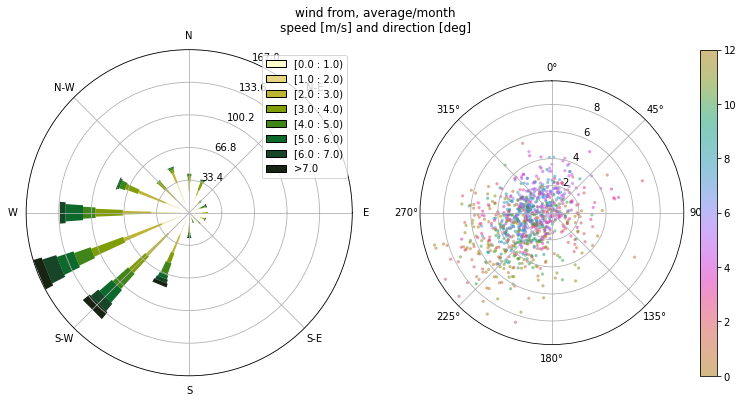

In [46]:
slr.plots.wind_plot(monthly_wind_df)

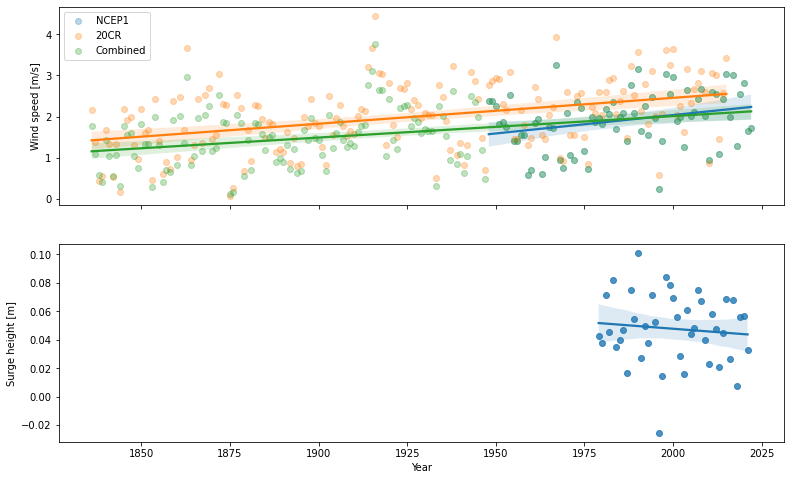

In [47]:
slr.plots.wind_trends(annual_wind_products, annual_gtsm_df);

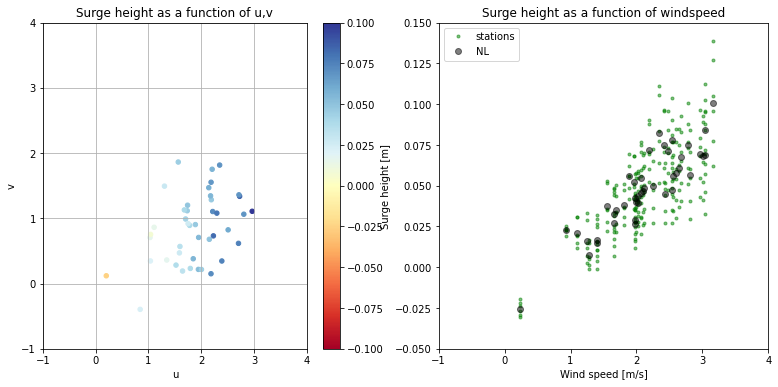

In [48]:
slr.plots.surge_vs_wind(annual_gtsm_df, annual_wind_df);

In [49]:
selected_stations = slr.psmsl.add_series_to_stations(selected_stations, wind_product=wind_product)
# each station should now have surge

found point 52.3799 3.75
found point 53.0 3.0


Now that we have all data downloaded. We added wind and the surge to the annual data for each station, we can compute the mean.

In [50]:
# compute the mean, only for annual
selected_stations = slr.psmsl.add_aggregated_stations(selected_stations)


<AxesSubplot:xlabel='year'>

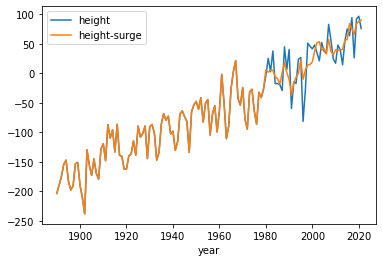

In [51]:
# pick the station
if drop_delfzijl:
    mean_df = selected_stations.loc[10001, "rlr_annual"]
else:
    mean_df = selected_stations.loc[10000, "rlr_annual"]

# Compute surge anomaly corrected waterlevel
mean_df['height-surge'] = mean_df['height'] - (mean_df['surge'] - mean_df['surge'].mean()) * 1000
mean_df.plot('year', ['height', 'height-surge'])


In [52]:
bokeh.io.show(
    slr.plots.timeseries_plot(
        selected_stations=selected_stations, 
        mean_df=mean_df, 
        dataset_name=default_dataset_name
    )
)


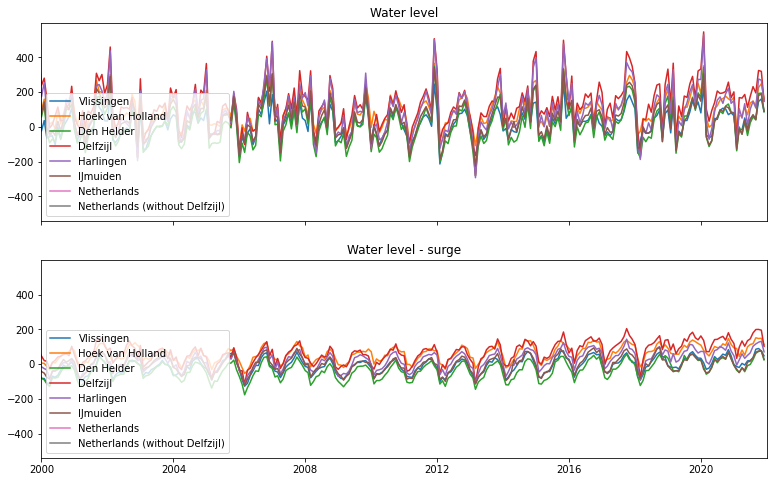

In [53]:
slr.plots.surge_vs_waterlevel(
    selected_stations
)

In [54]:
bokeh.io.show(
    slr.plots.timeseries_plot(
        selected_stations=selected_stations, 
        mean_df=mean_df, 
        dataset_name='rlr_monthly'
    )
)

In [55]:
slr.tables.top_n_tables(selected_stations)

Methods
=====
Now we can define the statistical model. The "current sea-level rise" is defined by the following formula. Please note that t is relative to the epoch of 1970. This model is referred to as `linear_model` in the code. 
$H(t) = a + b_{trend}(t) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t)$

The terms are refered to as Constant ($a$), Trend ($b_{trend}$), Nodal U ($b_u$) and Nodal V ($b_v$), Wind ($b_{wind^2}$), the autoregressive term $\varepsilon(t-1)$ and error $\varepsilon$. 


Alternative models are used to detect if sea-level rise is increasing. These models include the broken linear model, defined by a possible change in trend starting at 1993. This timespan is the start of the "satellite era" (start of TOPEX/Poseidon measurements), it is also often referred to as the start of acceleration because the satellite measurements tend to show a higher rate of sea level than the "tide-gauge era" (1900-2000). If this model fits better than the linear model, one could say that there is a "increase in sea-level rise".  This model is refered to as `broken_linear_model`. These models are covered in the section [Sea-level acceleration](#Is-there-a-sea-level-acceleration?).

$H(t) = a + b_{trend}(t) + b_{broken}(t > 1993)*(t-1993) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t)$

Another way to look at increased sea-level rise is to look at sea-level acceleration. To detect sea-level acceleration one can use a quadratic model. This model is referred to as `quadratic_model`. 

$H(t) = a + b_{trend}(t) + b_{quadratic}(t*t) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t)$



We can compare the model with and without wind. Wind drives the storm surge at the coast. If there is a strong wind blowing it can raise the waterlevel by meters, 2 meter is not uncommon. If the wind keeps blowing for two days this will raise the annual averaged waterlevel by more than a centimeter, even if it occurs during low tide. 
We can verify that wind is an important factor for the average sea level by comparing the model with and without wind. 
Things to check for include: 
- Durbin Watson should be >1 for no worries, >2 for no autocorrelation
- JB should be non-significant for normal residuals
- abs(x2.t) + abs(x3.t) should be > 3, otherwise adding nodal is not useful
- The model with wind should also be significant better, check F value difference with 2 and N-5 degrees of freedom. 

In [56]:
# first the model without wind and AR (autogregressive components)
quantity = 'height'
yname = "Sea surface height"
if subtract_surge:
    quantity = "height-surge"
    yname = "Sea surface height - surge"

linear_without_wind_fit, linear_without_wind_names = slr.models.linear_model(
    mean_df, with_wind=False, with_ar=False, quantity=quantity
)
table = linear_without_wind_fit.summary(
    yname=yname, 
    xname=linear_without_wind_names, 
    title='Linear model without (1890-current)'
)
IPython.display.display(table)

# and then the model with wind
linear_with_wind_fit, linear_with_wind_names = slr.models.linear_model(
    mean_df, 
    with_wind=True, 
    with_ar=False,
    quantity=quantity
)
table = linear_with_wind_fit.summary(
    yname=yname, 
    xname=linear_with_wind_names,
    title='Linear model with wind (1948-current)'
)
IPython.display.display(table)

# Wikipedia, based on Akaike(1974): Given a set of candidate models 
# for the data, the preferred model is the one with the minimum AIC value. 
if (linear_without_wind_fit.aic < linear_with_wind_fit.aic):
    print('The linear model without wind is a higher quality model (smaller AIC) than the linear model with wind.')
    linear_fit = linear_without_wind_fit
    with_wind = False
else:
    print('The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.')
    linear_fit = linear_with_wind_fit
    with_wind = True

if subtract_surge:
    linear_fit = linear_without_wind_fit
    with_wind = False
    print("We are not modelling wind because we are already modelling surge. Otherwise we would correct for wind twice over the period where we have surge.")
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Linear model without (1890-current)                          
======================================================================================
Dep. Variable:     Sea surface height - surge   R-squared:                       0.873
Model:                                    OLS   Adj. R-squared:                  0.870
Method:                         Least Squares   F-statistic:                     352.6
Date:                        Fri, 18 Nov 2022   Prob (F-statistic):           1.15e-61
Time:                                00:57:49   Log-Likelihood:                -626.70
No. Observations:                         132   AIC:                             1261.
Df Residuals:                             128   BIC:                             1273.
Df Model:                                   3                                         
Covariance Type:                          HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      10.8134      2.660      4.066      0.000       5.600      16.026
Trend          1.9202      0.059     32.373      0.000       1.804       2.036
Nodal U        5.2139      3.518      1.482      0.138      -1.681      12.109
Nodal V      -12.7599      3.346     -3.813      0.000     -19.319      -6.201
==============================================================================
Omnibus:                        5.390   Durbin-Watson:                   1.697
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                5.266
Skew:                          -0.489   Prob(JB):                       0.0719
Kurtosis:                       3.006   Cond. No.                         58.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Linear model with wind (1948-current)                         
======================================================================================
Dep. Variable:     Sea surface height - surge   R-squared:                       0.919
Model:                                    OLS   Adj. R-squared:                  0.915
Method:                         Least Squares   F-statistic:                     413.6
Date:                        Fri, 18 Nov 2022   Prob (F-statistic):           2.39e-76
Time:                                00:57:49   Log-Likelihood:                -597.49
No. Observations:                         132   AIC:                             1207.
Df Residuals:                             126   BIC:                             1224.
Df Model:                                   5                                         
Covariance Type:                          HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -34.0005      5.312     -6.401      0.000     -44.411     -23.590
Trend          1.8742      0.050     37.165      0.000       1.775       1.973
Nodal U        3.8061      2.735      1.392      0.164      -1.554       9.166
Nodal V      -11.9809      2.770     -4.326      0.000     -17.409      -6.553
Wind $u^2$     7.0292      0.728      9.658      0.000       5.603       8.456
Wind $v^2$    -0.0890      1.059     -0.084      0.933      -2.164       1.986
==============================================================================
Omnibus:                        1.458   Durbin-Watson:                   1.484
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                1.017
Skew:                          -0.175   Prob(JB):                        0.601
Kurtosis:                       3.250   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.
We are not modelling wind because we are already modelling surge. Otherwise we would correct for wind twice over the period where we have surge.


In [57]:

fig = slr.plots.wind_vs_no_wind(
    mean_df=mean_df, 
    quantity=quantity, 
    yname=yname,
    linear_with_wind_fit=linear_with_wind_fit, 
    linear_without_wind_fit=linear_without_wind_fit
)
bokeh.io.show(fig)

Regional variability
=====================
It is known that the sea-level rise is not constant along the coast. The figures below show that the sea-level is rising faster at some stations. Some of these variations go back to the 1900's. There are several coastal interventions with known effect to the stations. The construction of the [Afsluitdijk](https://en.wikipedia.org/wiki/Afsluitdijk) (1927-1932), the [Oosterscheldekering](https://en.wikipedia.org/wiki/Oosterscheldekering) (1969-1987), the [Maeslantkering](https://en.wikipedia.org/wiki/Maeslantkering) (1991-1997) all have influence on the mean sea level, mainly due to changes in tidal amplitudes. 

Using the mean of the six tidal guages is the current approach. There are alternatives, for example one can use the principal component of the differences (between months/years). It is then assumed that only the common variance shared accross all stations is representative of the shared sea level. Most of the variance is shared between all stations and this results in a similar trend as using the mean. This method is referred to as EOF, PCA or SSA. See the analysis folder for an example.

In [58]:
station_fits = {}
for name, station in selected_stations.iterrows():
    df = station[default_dataset_name]
    df = df[df.year >= 1890]
    fit, linear_names = slr.models.linear_model(df, with_wind=with_wind, quantity=quantity)
    smry = fit.summary(xname=linear_names, title=station['name'])
    # somehow a formatted name is not showing up
    print(station['name'])
    station_fits[name] = fit

    IPython.display.display(smry.tables[1])

Vlissingen


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-48.2948,3.385,-14.267,0.000,-54.929,-41.660
Trend,2.1672,0.094,23.156,0.000,1.984,2.351
Nodal U,4.9914,4.720,1.057,0.290,-4.260,14.243
Nodal V,-14.0422,4.645,-3.023,0.002,-23.145,-4.939


Hoek van Holland


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,28.7206,3.639,7.893,0.000,21.589,35.852
Trend,2.3688,0.080,29.694,0.000,2.212,2.525
Nodal U,0.7813,5.097,0.153,0.878,-9.208,10.771
Nodal V,-10.5946,4.603,-2.302,0.021,-19.615,-1.574


Den Helder


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-9.5852,3.723,-2.574,0.010,-16.883,-2.288
Trend,1.5356,0.084,18.246,0.000,1.371,1.701
Nodal U,5.5969,4.687,1.194,0.232,-3.589,14.783
Nodal V,-14.9597,4.946,-3.024,0.002,-24.654,-5.265


Delfzijl


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,91.7537,4.303,21.324,0.000,83.320,100.187
Trend,2.0280,0.106,19.105,0.000,1.820,2.236
Nodal U,4.4737,5.970,0.749,0.454,-7.227,16.174
Nodal V,-15.1521,5.043,-3.005,0.003,-25.036,-5.268


Harlingen


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,82.6200,4.341,19.033,0.000,74.112,91.128
Trend,1.3726,0.099,13.922,0.000,1.179,1.566
Nodal U,2.7236,5.503,0.495,0.621,-8.063,13.510
Nodal V,-12.2377,5.060,-2.419,0.016,-22.155,-2.321


IJmuiden


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,0.9349,4.295,0.218,0.828,-7.484,9.354
Trend,2.0889,0.113,18.565,0.000,1.868,2.309
Nodal U,11.0276,5.905,1.868,0.062,-0.546,22.601
Nodal V,-14.4257,5.487,-2.629,0.009,-25.181,-3.671


Netherlands


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,24.3622,3.174,7.675,0.000,18.141,30.583
Trend,1.9290,0.073,26.539,0.000,1.786,2.071
Nodal U,4.9393,4.185,1.180,0.238,-3.262,13.141
Nodal V,-13.5185,3.875,-3.488,0.000,-21.114,-5.923


Netherlands (without Delfzijl)


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,10.8896,3.102,3.510,0.000,4.809,16.970
Trend,1.9090,0.071,27.074,0.000,1.771,2.047
Nodal U,5.0348,4.077,1.235,0.217,-2.955,13.025
Nodal V,-13.2072,3.850,-3.431,0.001,-20.752,-5.662


In [59]:
station_fits = {}
for name, station in selected_stations.iterrows():
    df = station[default_dataset_name]
    df = df[df.year >= 1890]
    fit, linear_names = slr.models.broken_linear_model(df, with_wind=with_wind, quantity=quantity)
    smry = fit.summary(xname=linear_names, title=station['name'])
    # somehow a formatted name is not showing up
    print(station['name'])
    station_fits[name] = fit

    IPython.display.display(smry.tables[1])

Vlissingen


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-50.6376,4.794,-10.564,0.000,-60.033,-41.242
Trend,2.1078,0.135,15.591,0.000,1.843,2.373
+trend (1993),0.4811,0.550,0.875,0.382,-0.597,1.559
Nodal U,5.2425,4.628,1.133,0.257,-3.828,14.313
Nodal V,-13.8244,4.617,-2.994,0.003,-22.874,-4.775


Hoek van Holland


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,25.6239,5.365,4.776,0.000,15.108,36.140
Trend,2.2906,0.121,18.946,0.000,2.054,2.528
+trend (1993),0.6384,0.580,1.100,0.271,-0.499,1.776
Nodal U,1.1236,5.068,0.222,0.825,-8.810,11.057
Nodal V,-10.3106,4.552,-2.265,0.024,-19.232,-1.389


Den Helder


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-15.1991,5.124,-2.966,0.003,-25.242,-5.156
Trend,1.3942,0.117,11.959,0.000,1.166,1.623
+trend (1993),1.1635,0.593,1.963,0.050,0.002,2.325
Nodal U,6.2427,4.430,1.409,0.159,-2.440,14.925
Nodal V,-14.4615,4.749,-3.045,0.002,-23.770,-5.153


Delfzijl


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,82.6496,5.420,15.248,0.000,72.026,93.273
Trend,1.7994,0.133,13.574,0.000,1.540,2.059
+trend (1993),1.8869,0.678,2.784,0.005,0.558,3.215
Nodal U,5.5245,5.517,1.001,0.317,-5.289,16.338
Nodal V,-14.3270,4.623,-3.099,0.002,-23.388,-5.266


Harlingen


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,73.2011,5.489,13.336,0.000,62.443,83.959
Trend,1.1365,0.125,9.128,0.000,0.893,1.381
+trend (1993),1.9558,0.676,2.893,0.004,0.631,3.281
Nodal U,3.8258,4.959,0.771,0.440,-5.894,13.545
Nodal V,-11.3905,4.586,-2.484,0.013,-20.379,-2.402


IJmuiden


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,0.7598,6.087,0.125,0.901,-11.170,12.690
Trend,2.0844,0.162,12.837,0.000,1.766,2.403
+trend (1993),0.0359,0.734,0.049,0.961,-1.402,1.474
Nodal U,11.0460,5.913,1.868,0.062,-0.543,22.635
Nodal V,-14.4092,5.466,-2.636,0.008,-25.122,-3.696


Netherlands


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,19.3840,4.354,4.452,0.000,10.850,27.918
Trend,1.8039,0.101,17.849,0.000,1.606,2.002
+trend (1993),1.0353,0.513,2.020,0.043,0.031,2.040
Nodal U,5.5263,3.984,1.387,0.165,-2.282,13.334
Nodal V,-13.0858,3.713,-3.525,0.000,-20.362,-5.809


Netherlands (without Delfzijl)


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,6.7320,4.345,1.549,0.121,-1.785,15.249
Trend,1.8045,0.101,17.923,0.000,1.607,2.002
+trend (1993),0.8642,0.505,1.713,0.087,-0.125,1.853
Nodal U,5.5231,3.923,1.408,0.159,-2.165,13.212
Nodal V,-12.8462,3.732,-3.442,0.001,-20.161,-5.532


In [60]:
p = slr.plots.station_comparison_linear_vs_broken_linear(
    selected_stations=selected_stations, 
    quantity=quantity, 
    yname=yname, 
    with_wind=with_wind,
    dataset_name=default_dataset_name
)
bokeh.io.show(p)


Another thing we can look at is the regional variability of unexplained variance. The largest peaks are found in Delfzijl at the start of the measurements. The measured waterlevel was lower in that year. Delfzijl is more affected by storm surges than most other stations due to it's position in the Eems. Another outlier is the measurement in the 30's in Den Helder, this is likely due to the construction of the Afsluitdijk. The other residuals mostly occur on all stations at the same time. This indicates that it is more likely that our estimate of the wind is not optimal yet. We do see a periodicity in the residuals of about 6 years. This does not match with any of the known climate indices. 
Variance descreasess after 1948 because the reanalysis of wind is included after that. 

Is there a sea-level acceleration?
==================

The following section computes two common models to detect sea-level acceleration.  The broken linear model expects that sea level has been rising faster since 1990. The quadratic model assumes that the sea-level is accelerating continuously. Both models are compared to the linear model. The extra terms are tested for significance and the AIC is computed to see which model is "better". 

In [61]:
# use wind if it was a better model
broken_linear_fit, broken_linear_names = slr.models.broken_linear_model(
    mean_df, 
    with_wind=with_wind, 
    quantity=quantity
)

In [62]:
quadratic_fit, quadratic_names = slr.models.quadratic_model(mean_df, with_wind=with_wind, quantity=quantity)
broken_quadratic_fit, broken_quadratic_names = slr.models.broken_quadratic_model(
    mean_df, 
    with_wind=with_wind,
    quantity=quantity,
    start_acceleration=1960
    
)

In [63]:
# summary of the broken linear model
print('autoregressive parameter rho = %s' % broken_linear_fit.history['rho'][-1])
IPython.display.display(broken_linear_fit.summary(yname='Sea-surface height', xname=broken_linear_names))


autoregressive parameter rho = [0.12548306]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.844
Model:                          GLSAR   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     218.8
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           1.08e-55
Time:                        00:57:50   Log-Likelihood:                -619.16
No. Observations:                 131   AIC:                             1248.
Df Residuals:                     126   BIC:                             1263.
Df Model:                           4                                         
Covariance Type:                  HC0                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant          6.7320      4.345      1.549      0.121      -1.785      15.249
Trend             1.8045      0.101     17.923      0.000       1.607       2.002
+trend (1993)     0.8642      0.505      1.713      0.087      -0.125       1.853
Nodal U           5.5231      3.923      1.408      0.159      -2.165      13.212
Nodal V         -12.8462      3.732     -3.442      0.001     -20.161      -5.532
==============================================================================
Omnibus:                        3.724   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                3.494
Skew:                          -0.400   Prob(JB):                        0.174
Kurtosis:                       3.014   Cond. No.                         57.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [64]:
# summary of the quadratic model
print('autoregressive parameter rho = %s' % quadratic_fit.history['rho'][-1])

quadratic_fit.summary(yname='Sea-surface height', xname=quadratic_names)

autoregressive parameter rho = [0.14186353]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.837
Model:                          GLSAR   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     194.9
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           5.93e-53
Time:                        00:57:50   Log-Likelihood:                -620.01
No. Observations:                 131   AIC:                             1250.
Df Residuals:                     126   BIC:                             1264.
Df Model:                           4                                         
Covariance Type:                  HC0                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Constant (in year {epoch})     8.1076      4.234      1.915      0.056      -0.192      16.407
Trend                          1.9712      0.086     22.873      0.000       1.802       2.140
Acceleration                   0.0022      0.002      1.100      0.271      -0.002       0.006
Nodal U                        5.0289      4.019      1.251      0.211      -2.848      12.906
Nodal V                      -13.0583      3.843     -3.398      0.001     -20.590      -5.526
==============================================================================
Omnibus:                        4.923   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.609
Skew:                          -0.456   Prob(JB):                       0.0998
Kurtosis:                       3.107   Cond. No.                     3.36e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 3.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
# summary of the broken quadratic model
print('autoregressive parameter rho = %s' % broken_quadratic_fit.history['rho'][-1])
IPython.display.display(broken_quadratic_fit.summary(yname='Sea-surface height', xname=broken_quadratic_names))


autoregressive parameter rho = [0.12872249]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.843
Model:                          GLSAR   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     209.3
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           1.25e-54
Time:                        00:57:50   Log-Likelihood:                -619.31
No. Observations:                 131   AIC:                             1249.
Df Residuals:                     126   BIC:                             1263.
Df Model:                           4                                         
Covariance Type:                  HC0                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Constant (in year {start_acceleration})   -12.9791      4.424     -2.934      0.003     -21.650      -4.309
Trend                                       1.7625      0.120     14.688      0.000       1.527       1.998
Acceleration from 1960                      0.0071      0.004      1.641      0.101      -0.001       0.015
Nodal U                                     5.3534      3.929      1.363      0.173      -2.347      13.054
Nodal V                                   -12.9787      3.767     -3.446      0.001     -20.361      -5.596
==============================================================================
Omnibus:                        4.217   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                3.916
Skew:                          -0.422   Prob(JB):                        0.141
Kurtosis:                       3.074   Cond. No.                     1.75e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
fits = [
    {
        "name": "broken_linear", 
        "aic": broken_linear_fit.aic,
        "F": broken_linear_fit.fvalue,
        "df": broken_linear_fit.df_model,
        "fit": broken_linear_fit,
        "names": broken_linear_names
    },
    {
        "name": "quadratic",
        "aic": quadratic_fit.aic,
        "F": quadratic_fit.fvalue,
        "df": quadratic_fit.df_model,
        "fit": quadratic_fit,
        "names": quadratic_names
    },
    {
        "name": "broken_quadratic",
        "aic": broken_quadratic_fit.aic,
        "F": broken_quadratic_fit.fvalue,
        "df": broken_quadratic_fit.df_model,
        "fit": broken_quadratic_fit,
        "names": broken_quadratic_names
    }
]
fits_df = pd.DataFrame(fits)
# Best acceleration model on top
fits_df = fits_df.sort_values('aic')
selected_fit = fits_df.iloc[0]
fits_df

,name,aic,F,df,fit,names
0,broken_linear,1248.320120,218.848420,4.0,<statsmodels.regression.linear_model.Regressio...,"[Constant, Trend, +trend (1993), Nodal U, Noda..."
2,broken_quadratic,1248.618569,209.302583,4.0,<statsmodels.regression.linear_model.Regressio...,"[Constant (in year {start_acceleration}), Tren..."
1,quadratic,1250.014564,194.948605,4.0,<statsmodels.regression.linear_model.Regressio...,"[Constant (in year {epoch}), Trend, Accelerati..."


# Constant wind trend
Here we compute the linear model with constant wind and tide

In [67]:
# before reanalysis started wind  is filled  in with mean,  let's use it from there
mean_wind = mean_df.set_index('year').loc[1890][['u2', 'v2']]
const = linear_with_wind_fit.params['const'] 
trend = linear_with_wind_fit.params['x1'] 
u2 = linear_with_wind_fit.params['x4'] 
v2 = linear_with_wind_fit.params['x5'] 

# linear_with_wind_fit.predict(mean_df)
linear_with_wind_fit.model.exog.shape, linear_with_wind_fit.model.exog_names
exog_df = pd.DataFrame(
    linear_with_wind_fit.model.exog, 
    columns=linear_with_wind_fit.model.exog_names
).copy()
msg = 'Check variable numbers in code below, they changed'
assert linear_with_wind_names == ['Constant', 'Trend', 'Nodal U', 'Nodal V', 'Wind $u^2$', 'Wind $v^2$'], msg
# take 0 nodal tide
exog_df['x2'] = 0 # 
exog_df['x3'] = 0 # 
# take the average wind
exog_df['x4'] = mean_wind['u2']
exog_df['x5'] = mean_wind['v2']
linear_with_mean_wind = linear_with_wind_fit.predict(exog_df)
linear_with_mean_wind_prediction = linear_with_wind_fit.get_prediction(exog=exog_df)
linear_with_mean_wind_confidence_interval = linear_with_mean_wind_prediction.conf_int(obs=False)
linear_with_mean_wind_prediction_interval = linear_with_mean_wind_prediction.conf_int(obs=True)
linear_with_wind_confidence_interval = linear_with_wind_fit.get_prediction().conf_int(obs=False)
linear_with_wind_prediction_interval = linear_with_wind_fit.get_prediction().conf_int(obs=True)



In [68]:
# Extract parameters  and input parameters of the linear model for tide

# Nodal parameters should be stored as x2, x3 in the fit
assert linear_with_wind_names[linear_with_wind_fit.model.exog_names.index('x2')] == 'Nodal U'
assert linear_with_wind_names[linear_with_wind_fit.model.exog_names.index('x3')] == 'Nodal V'


exog_u = linear_with_wind_fit.model.exog[:, linear_with_wind_fit.model.exog_names.index('x2')]
param_u = linear_with_wind_fit.params['x2']
exog_v = linear_with_wind_fit.model.exog[:, linear_with_wind_fit.model.exog_names.index('x3')]
param_v = linear_with_wind_fit.params['x3']

sea_surface_height_due_to_tide = exog_u * param_u + exog_v * param_v

Text(0, 0.5, 'sea surface height due to tide [mm]')

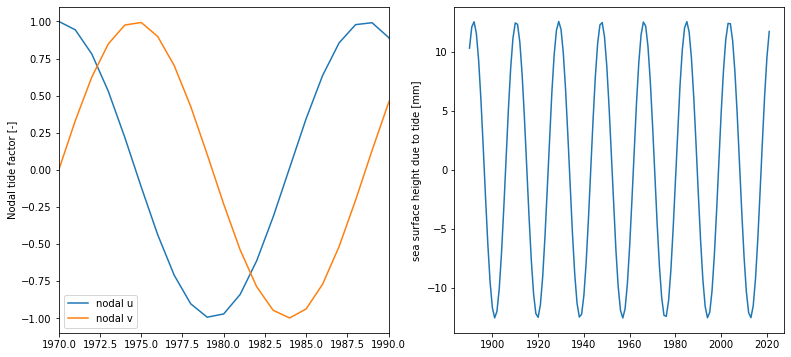

In [69]:
# This should show a cos (u) and sine (v) function with 1 period
fig, axes = plt.subplots(ncols=2, figsize=(13, 6))
ax = axes[0]
ax.plot(mean_df['year'], exog_u, label='nodal u')
ax.plot(mean_df['year'], exog_v, label='nodal v')
ax.legend()
ax.set_ylabel('Nodal tide factor [-]')
ax.set_xlim(1970, 1990)
ax = axes[1]
ax.plot(mean_df['year'], sea_surface_height_due_to_tide, label='sea surface height due to tide [mm]')
ax.set_ylabel('sea surface height due to tide [mm]')

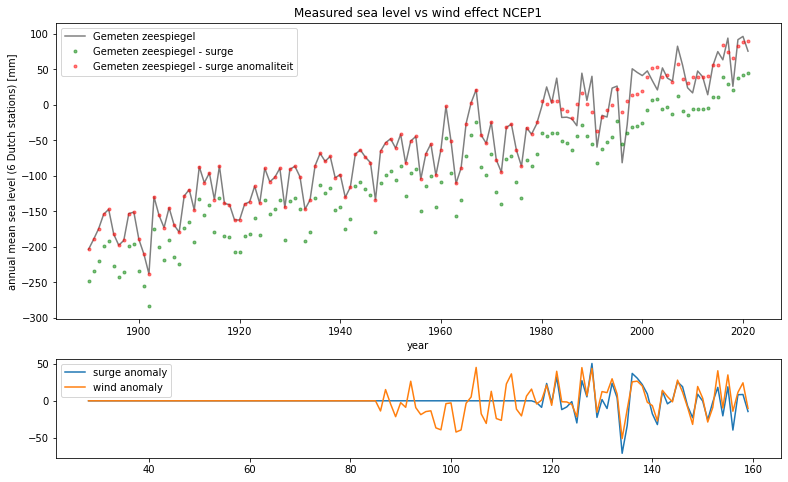

In [70]:
wind_effect = linear_with_wind_fit.params.loc['x4'] * mean_df.u2 + linear_with_wind_fit.params.loc['x5'] * mean_df.v2
wind_anomaly = wind_effect - wind_effect.mean()

correct_wind = False
correct_surge = True
fig, axes = plt.subplots(figsize=(13, 8), nrows=2, gridspec_kw=dict(height_ratios=(3, 1)))
axes[0].plot(mean_df.year, mean_df.height, 'k-', alpha=0.5, label='Gemeten zeespiegel ')
if correct_wind:
    axes[0].plot(mean_df.year, mean_df.height - wind_effect, 'g-', alpha=0.5, label='Gemeten zeespiegel - wind')
if correct_surge:
    axes[0].plot(mean_df.year, mean_df.height - mean_df.surge * 1000, 'g.', alpha=0.5, label='Gemeten zeespiegel - surge')
if correct_wind:
    axes[0].plot(mean_df.year, mean_df.height - wind_anomaly, 'r-', alpha=0.5, label='Gemeten zeespiegel - wind anomaliteit')
if correct_surge:
    axes[0].plot(mean_df.year, mean_df.height - (mean_df.surge - mean_df.surge.mean())* 1000, 'r.', alpha=0.5, label='Gemeten zeespiegel - surge anomaliteit')
# ax.set_xlim(1920, 2022)
# if correct_surge:
#     ax.set_xlim(1970, 2022)
axes[0].set_title(f'Measured sea level vs wind effect {wind_product}')
axes[0].legend(loc='best')
axes[0].set_xlabel('year')
axes[0].set_ylabel(f'annual mean sea level ({len(main_stations)} Dutch stations) [mm]')
axes[1].plot((mean_df.surge - mean_df.surge.mean()) * 1000, label='surge anomaly')
axes[1].plot(wind_anomaly, label='wind anomaly')
axes[1].legend()


In [93]:
def model_compare_plot():
    colors = bokeh.palettes.Category10[10]
    
    fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
    
    fig.circle(mean_df.year, mean_df[quantity], line_width=3, legend_label=f'Observed {yname}', color='black', alpha=0.5)
    fig.circle(mean_df.year,  mean_df[quantity] - wind_anomaly, line_width=3, legend_label=f'Observed {quantity}- wind anomaly', color='red', alpha=0.5)
    
    # obser
    fig.line(mean_df.year, linear_with_wind_fit.predict(), line_width=3, legend_label='Linear (with wind)', color=colors[0])
    fig.patch(
        np.r_[mean_df.year[::-1], mean_df.year],
        np.r_[linear_with_wind_confidence_interval[::-1, 0], linear_with_wind_confidence_interval[:, 1]],
        color=colors[0],
        alpha=0.3,
        legend_label='Linear (with wind)'
    )
    fig.patch(
        np.r_[mean_df.year[::-1], mean_df.year],
        np.r_[linear_with_wind_prediction_interval[::-1, 0], linear_with_wind_prediction_interval[:, 1]],
        color=colors[0],
        alpha=0.1,
        legend_label='Linear (with wind)'
    )

    fig.line(mean_df.year, linear_with_mean_wind, line_width=3, color=colors[2], legend_label='Linear (mean wind, 0 tide)')
    fig.patch(
        np.r_[mean_df.year[::-1], mean_df.year],
        np.r_[linear_with_mean_wind_confidence_interval[::-1, 0], linear_with_mean_wind_confidence_interval[:, 1]],
        color=colors[2],
        alpha=0.3, 
        legend_label='Linear (mean wind, 0 tide)'
    )
    fig.patch(
        np.r_[mean_df.year[::-1], mean_df.year],
        np.r_[linear_with_mean_wind_prediction_interval[::-1, 0], linear_with_mean_wind_prediction_interval[:, 1]],
        color=colors[2],
        alpha=0.1, 
        legend_label='Linear (mean wind, 0 tide)'
    )
    
    # alternative models
    
    fig.line(mean_df.year, linear_without_wind_fit.predict(), line_width=3, legend_label='Linear (no wind)', color=colors[1])    
    fig.line(mean_df.year, broken_linear_fit.predict(), line_width=3, color=colors[3], legend_label='Broken (with wind)')
    fig.line(mean_df.year, quadratic_fit.predict(), line_width=3, color=colors[4], legend_label='Quadratic (with wind)')
    fig.line(mean_df.year, broken_quadratic_fit.predict(), line_width=3, color=colors[5], legend_label='Broken quadratic (acceleration in 1960, with wind)')
    
    fig.line(mean_df.year, mean_df.height.rolling(18, center=True).mean(), line_width=3, color=colors[6], legend_label='Rolling 18 year mean (centered)')
    fig.line(mean_df.year, mean_df.height.rolling(7, center=True).mean(), line_width=3, color=colors[7], legend_label='Rolling 7 year mean (centered)')
    
    fig.legend.location = "top_left"
    fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
    fig.xaxis.axis_label = 'year'
    fig.legend.click_policy = "hide"
    return fig
bokeh.io.show(model_compare_plot())

# Export
Here we export the data in csv format. This information is often requested by others.


In [72]:
export_df = mean_df.copy().reset_index()
export_df['predicted_linear_with_wind'] = linear_with_wind_fit.predict()
export_df['predicted_linear_without_wind'] = linear_without_wind_fit.predict()
export_df['predicted_linear_mean_wind'] = linear_with_mean_wind
export_df['predicted_linear_mean_wind_ci_025'] = linear_with_mean_wind_confidence_interval[:, 0]
export_df['predicted_linear_mean_wind_ci_975'] = linear_with_mean_wind_confidence_interval[:, 1]
export_df['predicted_linear_mean_wind_pi_025'] = linear_with_mean_wind_prediction_interval[:, 0]
export_df['predicted_linear_mean_wind_pi_975'] = linear_with_mean_wind_prediction_interval[:, 1]
export_df['sea_surface_height_due_to_tide']  = sea_surface_height_due_to_tide
export_df['date'] = export_df['year'].apply(lambda year: datetime.date(year=int(year), month=1, day=1))
header = """\
# Sea surface height for the Netherlands based on the 6 main tide gauges. 
# Cite https://doi.org/10.2112/JCOASTRES-D-11-00169.1 (method) https://doi.org/10.5281/zenodo.1065964 (data)
# Lineage: https://doi.org/10.5281/zenodo.1065964 (notebooks/dutch-sea-level-monitor.ipynb)
# year -> year over which sea-level is averaged
# date -> first day of the year over which the sea level is averaged
# height -> mean sea surface height over main tide gauges, based on PSMSL RLR [mm relative to NAP(2005)]
# u2/v2 -> signed squared mean wind velocity offshore [m2/s2]
# surge -> sea surface height correction due to air pressure and wind [m]
# predicted_linear_with_wind -> fitted sea surface height based on linear model with wind and 0 tide [mm relative to NAP(2005)]
# predicted_linear_without_wind -> fitted sea surface height based on linear model with tide [mm relative to NAP(2005)]
# predicted_linear_mean_wind  -> fitted sea surface height based on linear model with wind and mean nodal tide   [mm relative to NAP(2005)]
# predicted_linear_mean_wind_ci_025  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 2.5% confidence interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_ci_975  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 97.5% confidence interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_pi_025  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 2.5% prediction interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_pi_975  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 97.5% prediction interval [mm relative to NAP(2005)]
# sea_surface_height_due_to_tide  -> fitted nodal tide based on linear model with wind [mm relative to NAP(2005)]
"""
stream = io.StringIO()
stream.write(header)
export_df.to_csv(stream, escapechar='#', index=False)
date = datetime.datetime.now().date()
path = pathlib.Path('../data/deltares/results/dutch-sea-level-monitor-export-{}.csv'.format(date.isoformat()))
path.write_text(stream.getvalue())

34862

In [73]:
header = """\
# Sea surface height for the Netherlands  for the 6 main tide gauges. 
# Cite https://doi.org/10.2112/JCOASTRES-D-11-00169.1 (method) https://doi.org/10.5281/zenodo.1065964 (data)
# Lineage: https://doi.org/10.5281/zenodo.1065964 (notebooks/dutch-sea-level-monitor.ipynb)
# year -> year over which sea-level is averaged
# date -> first day of the year over which the sea level is averaged
# height -> mean sea surface height over main tide gauges, based on PSMSL RLR [mm relative to NAP(2005)]
# u2/v2 -> signed squared mean wind velocity offshore [m2/s2]
# predicted_linear_with_wind -> fitted sea surface height based on linear model with wind and 0 tide [mm relative to NAP(2005)]
"""
dfs = []
for name, station in selected_stations.iterrows():
    df = station[default_dataset_name]
    df = df[df.year >= 1890].copy()
    fit = station_fits[name]
    predicted_linear_with_wind = fit.predict()   
    df['predicted_linear_with_wind'] = predicted_linear_with_wind
    dfs.append(df.reset_index())
export_stations_df = pd.concat(dfs)
stream = io.StringIO()
stream.write(header)
export_stations_df.to_csv(stream, escapechar='#', index=False)
date = datetime.datetime.now().date()
path = pathlib.Path('../data/deltares/results/dutch-sea-level-monitor-export-stations-{}.csv'.format(date.isoformat()))
path.write_text(stream.getvalue())

159243

Conclusions
======
Below are some statements that depend on the output calculated above. 

In [92]:
# this section asserts that we have wind selected (because we use the with_mean_wind fit, which is only available if there is wind)
selected_model = selected_fit['fit']

n_stations = 6
if drop_delfzijl:
    n_stations = 5
if with_wind:
    observed = mean_df.height.iloc[-1] / 10.0 # mm to cm
    height_corrected_cm = linear_with_mean_wind.iloc[-1] / 10 # mm to cm
    height_predicted_cm = linear_with_wind_fit.predict()[-1]/10.0 #mm to cm
    current_year = int(mean_df['year'].iloc[-1])
    rate = linear_fit.params.x1*100.0/10 # mm/yr to cm/century
    t_start = mean_df.year.iloc[0]
    t_end = mean_df.year.iloc[-1]

else:
    observed = mean_df.height.iloc[-1] / 10.0 # mm to cm
    height_corrected_cm = mean_df['height-surge'].iloc[-1] / 10 # mm to cm
    height_predicted_cm = selected_model.predict()[-1] / 10.0 #mm to cm
    current_year = int(mean_df['year'].iloc[-1])
    
    if selected_fit['name'] == 'broken_linear':
        rate = selected_model.params['x1'] + selected_model.params['x2'] 
    else:
        raise ValueError("rate not defined yet for {selected_fit['name']}")
    t_start = mean_df.year.iloc[0]
    t_end = mean_df.year.iloc[-1]

msg = f'''
- The observed water level, based on the {n_stations} main tide gauges, in {current_year} was {observed:.1f} cm above NAP. 
- The 'current average waterlevel', as defined in the sea level monitor, for the year {current_year} is {height_predicted_cm:.1f} cm above NAP. This is the  sea surface height that we would expect based on tide and wind.
- In a year with average {"wind and tide" if with_wind else "surge"} we would have expected a sea level of {height_corrected_cm:.1f} cm. 
- The current sea-level rise is {rate:.1f} cm/century based on the {selected_fit["name"]} model {"with" if with_wind else "without"} wind. 
'''

IPython.display.display_markdown(msg, raw=True)




- The observed water level, based on the 5 main tide gauges, in 2021 was 7.6 cm above NAP. 
- The 'current average waterlevel', as defined in the sea level monitor, for the year 2021 is 13.5 cm above NAP. This is the  sea surface height that we would expect based on tide and wind.
- In a year with average surge we would have expected a sea level of 12.1 cm. 
- The current sea-level rise is 2.7 cm/century based on the broken_linear model without wind. 


In [76]:
if (linear_fit.aic < quadratic_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the quadratic model.')
else:
    print('The quadratic model is a higher quality model (smaller AIC) than the linear model.')
if (quadratic_fit.pvalues['x2'] < 0.05):
    print('The quadratic term is bigger than we would have expected under the assumption that there was no quadraticness.')
else:
    print('Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.')

The quadratic model is a higher quality model (smaller AIC) than the linear model.
Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.


In [77]:
if (linear_fit.aic < broken_linear_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the broken linear model.')
else:
    print('The broken linear model is a higher quality model (smaller AIC) than the linear model.')
if (broken_linear_fit.pvalues['x2'] < 0.05):
    print('The trend break is bigger than we would have expected under the assumption that there was no trend break.')
else:
    print('Under the assumption that there is no trend break, we would have expected a trend break as big as we have seen.')
    
    

The broken linear model is a higher quality model (smaller AIC) than the linear model.
Under the assumption that there is no trend break, we would have expected a trend break as big as we have seen.


In [78]:
# Show trends before and after 1993 for comparison with altimetry
broken_params = dict(zip(broken_linear_names, broken_linear_fit.params.values))
trend_since_1993 = broken_params['Trend'] + broken_params['+trend (1993)']
print('The trend since 1993 is {:.2f} mm/year. This period can be used to compare with satellite altimetry.'.format(trend_since_1993))
print('The trend before 1993 was {:.2f} mm/year'.format(broken_params['Trend']))


The trend since 1993 is 2.67 mm/year. This period can be used to compare with satellite altimetry.
The trend before 1993 was 1.80 mm/year
